Based on the EDA, performing the following actions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import scipy.stats as stats
from sklearn.metrics import silhouette_score

In [2]:
import warnings
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
merged_df = pd.read_csv("merged_file.csv")

In [4]:
# Assuming 'merged_df' is your preprocessed DataFrame and you have already identified numeric_cols
numeric_cols = merged_df.select_dtypes(include=['float64', 'int64']).columns

# Define the percentile thresholds
lower_percentile = 0.02
upper_percentile = 0.98

# Capping the outliers for all numerical features in the DataFrame
for col in numeric_cols:
    # Compute the 1st and 99th percentiles
    lower_bound = merged_df[col].quantile(lower_percentile)
    upper_bound = merged_df[col].quantile(upper_percentile)
    
    # Cap values below the 1st percentile to the 1st percentile value
    # Cap values above the 99th percentile to the 99th percentile value
    merged_df[col] = np.where(merged_df[col] < lower_bound, lower_bound, merged_df[col])
    merged_df[col] = np.where(merged_df[col] > upper_bound, upper_bound, merged_df[col])


In [5]:
merged_df.head()

,Country,Crop_Name,Year,Area harvested_ha,Production_t,Yield_100 g/ha,Export Quantity_t,Export Value_1000 USD,Import Quantity_t,Import Value_1000 USD,...,Area_to_Production_ratio,Area_Value_to_Pesticide_ratio,Pesticide_to_Production_ratio,Export_to_Production_ratio,Import_to_Production_ratio,Country_Production_Mean,Crop_Production_Median,Yearly_Pesticide_Sum,Country_Yield_Std,Crop_Emission_Total
0,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,0.367884,5.922299,0.004367,0.000207,0.0548,3.514974e+07,106178315.0,3.271649e+08,13073.599468,764660.6388
1,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,0.367884,5.922299,0.004367,0.000207,0.0548,3.514974e+07,106178315.0,3.271649e+08,13073.599468,764660.6388
2,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,0.367884,5.922299,0.004367,0.000207,0.0548,3.514974e+07,106178315.0,3.271649e+08,13073.599468,764660.6388
3,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,0.367884,5.922299,0.004367,0.000207,0.0548,3.514974e+07,106178315.0,3.271649e+08,13073.599468,764660.6388
4,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,0.367884,5.922299,0.004367,0.000207,0.0548,3.514974e+07,106178315.0,3.271649e+08,13073.599468,764660.6388


In [6]:
# List of relevant features
relevant_features = [
    'Country', 'Crop_Name', 'Year', 'Area harvested_ha', 'Production_t', 'Yield_100 g/ha',
    'Export Quantity_t', 'Export Value_1000 USD', 'Import Quantity_t', 'Import Value_1000 USD',
    'Emission_type', 'Emission_Value_kt', 'Gross_Production_Value_1000 USD', 'Area_Value_1000 ha',
    'Pesticide_Type', 'Pesticide_Value_t', 'Fertilizer_Usage_Value_kg/ha',
    'Emission_to_Production_ratio', 'Emission_to_Area_ratio', 'Emission_Value_per_Pesticide',
    'Area_to_Production_ratio'
]

In [7]:
# Create a new DataFrame with only the selected features
data_relevant = merged_df[relevant_features]

data_relevant.head()

,Country,Crop_Name,Year,Area harvested_ha,Production_t,Yield_100 g/ha,Export Quantity_t,Export Value_1000 USD,Import Quantity_t,Import Value_1000 USD,...,Emission_Value_kt,Gross_Production_Value_1000 USD,Area_Value_1000 ha,Pesticide_Type,Pesticide_Value_t,Fertilizer_Usage_Value_kg/ha,Emission_to_Production_ratio,Emission_to_Area_ratio,Emission_Value_per_Pesticide,Area_to_Production_ratio
0,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,6.4353,3568843.0,835814.0,Pesticides (total),141130.0,30.0631,1.991058e-07,5.412192e-07,0.000046,0.367884
1,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,6.4353,3568843.0,835814.0,Pesticides (total),141130.0,19.3971,1.991058e-07,5.412192e-07,0.000046,0.367884
2,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,6.4353,3568843.0,835814.0,Pesticides (total),141130.0,40.2513,1.991058e-07,5.412192e-07,0.000046,0.367884
3,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,6.4353,3568843.0,835814.0,Pesticides (total),141130.0,21.9175,1.991058e-07,5.412192e-07,0.000046,0.367884
4,Brazil,Maize (corn),2000.0,11890376.0,32321000.0,27182.0,6699.0,9366.0,1771194.0,201960.0,...,6.4353,3568843.0,835814.0,Pesticides (total),141130.0,5.3077,1.991058e-07,5.412192e-07,0.000046,0.367884


In [8]:
# Select only numerical features for the correlation matrix
numerical_features = data_relevant.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data_relevant[numerical_features].corr()

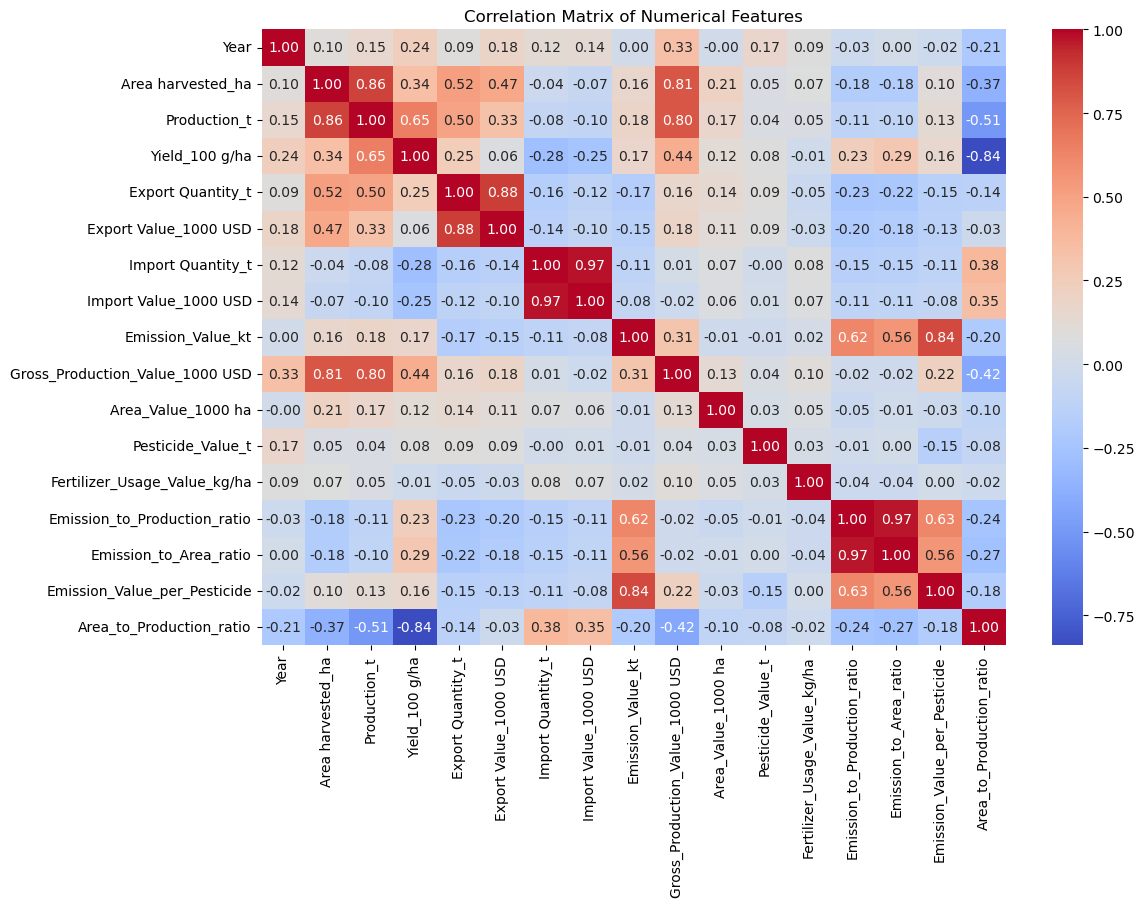

In [9]:
# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [10]:
# Dropping highly correlated features based on heatmap analysis
columns_to_drop = ['Area harvested_ha', 'Export Quantity_t', 'Import Value_1000 USD', 'Gross_Production_Value_1000 USD']
data_reduced = data_relevant.drop(columns=columns_to_drop)

In [11]:
# Function to calculate VIF for each feature
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data['feature'] = df.columns
    vif_data['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

In [12]:
#recalculate the VIF for the reduced dataset
vif_scores_reduced = calculate_vif(data_reduced.select_dtypes(include=['float64', 'int64', 'uint8']))
print(vif_scores_reduced.sort_values('VIF', ascending=False))

                         feature        VIF
0                           Year  61.411456
2                 Yield_100 g/ha  33.280659
9   Emission_to_Production_ratio  25.009138
10        Emission_to_Area_ratio  23.077749
12      Area_to_Production_ratio  15.948772
1                   Production_t   5.979949
5              Emission_Value_kt   4.641001
11  Emission_Value_per_Pesticide   4.369611
7              Pesticide_Value_t   2.442396
6             Area_Value_1000 ha   2.412640
3          Export Value_1000 USD   1.705579
8   Fertilizer_Usage_Value_kg/ha   1.500561
4              Import Quantity_t   1.486173


In [13]:
# Dropping the specified high VIF features
columns_to_drop_more = ['Yield_100 g/ha', 'Emission_to_Production_ratio', 'Emission_to_Area_ratio']
data_reduced_further = data_reduced.drop(columns=columns_to_drop_more)

In [14]:
data_reduced_further.head()

,Country,Crop_Name,Year,Production_t,Export Value_1000 USD,Import Quantity_t,Emission_type,Emission_Value_kt,Area_Value_1000 ha,Pesticide_Type,Pesticide_Value_t,Fertilizer_Usage_Value_kg/ha,Emission_Value_per_Pesticide,Area_to_Production_ratio
0,Brazil,Maize (corn),2000.0,32321000.0,9366.0,1771194.0,Crops total (Emissions N2O),6.4353,835814.0,Pesticides (total),141130.0,30.0631,0.000046,0.367884
1,Brazil,Maize (corn),2000.0,32321000.0,9366.0,1771194.0,Crops total (Emissions N2O),6.4353,835814.0,Pesticides (total),141130.0,19.3971,0.000046,0.367884
2,Brazil,Maize (corn),2000.0,32321000.0,9366.0,1771194.0,Crops total (Emissions N2O),6.4353,835814.0,Pesticides (total),141130.0,40.2513,0.000046,0.367884
3,Brazil,Maize (corn),2000.0,32321000.0,9366.0,1771194.0,Crops total (Emissions N2O),6.4353,835814.0,Pesticides (total),141130.0,21.9175,0.000046,0.367884
4,Brazil,Maize (corn),2000.0,32321000.0,9366.0,1771194.0,Crops total (Emissions N2O),6.4353,835814.0,Pesticides (total),141130.0,5.3077,0.000046,0.367884


In [15]:
vif_scores_updated = calculate_vif(data_reduced_further.select_dtypes(include=['float64', 'int64', 'uint8']))
print(vif_scores_updated.sort_values('VIF', ascending=False))

                        feature        VIF
0                          Year  12.977586
9      Area_to_Production_ratio   7.061414
4             Emission_Value_kt   4.137203
8  Emission_Value_per_Pesticide   4.079572
1                  Production_t   3.187067
6             Pesticide_Value_t   2.434507
5            Area_Value_1000 ha   2.369215
2         Export Value_1000 USD   1.642956
7  Fertilizer_Usage_Value_kg/ha   1.484445
3             Import Quantity_t   1.479326


In [16]:
# Define target variables
target_vars = ['Production_t', 'Export Value_1000 USD']

In [17]:
# Define numerical and categorical columns, excluding the target columns
numerical_cols = data_reduced_further.select_dtypes(include=['int64', 'float64']).columns.difference(target_vars).tolist()
categorical_cols = data_reduced_further.select_dtypes(include=['object']).columns.tolist()

In [18]:
# Create the preprocessing pipeline for numerical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # Standardize numerical features
])

In [19]:
# Create the preprocessing pipeline for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical features
])

In [20]:
# Combine all elements into a large transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [21]:
# Split data into training and testing sets based on the year
train = data_reduced_further[data_reduced_further['Year'] <= 2019]
test = data_reduced_further[data_reduced_further['Year'] > 2019]

# Drop the 'Year' column if it's no longer needed for modeling
X_train = train.drop(['Production_t', 'Export Value_1000 USD'], axis=1)
y_train_prod = train['Production_t']
y_train_export = train['Export Value_1000 USD']

X_test = test.drop(['Production_t', 'Export Value_1000 USD'], axis=1)
y_test_prod = test['Production_t']
y_test_export = test['Export Value_1000 USD']

## Linear Regression

In [22]:
# Create the full pipeline including the preprocessor and the Linear Regression model
pipeline_lr_prod = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [23]:
# Training the pipeline on the training data
pipeline_lr_prod.fit(X_train, y_train_prod) 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Area_Value_1000 ha',
                                                   'Area_to_Production_ratio',
                                                   'Emission_Value_kt',
                                                   'Emission_Value_per_Pesticide',
                                                   'Fertilizer_Usage_Value_kg/ha',
                                                   'Import Quantity_t',
                                                   'Pesticide_Value_t',
                                                   'Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Country', 'Crop_Name',
                                                   'Emission_type',
                                                   'Pesticide_Type'])])),
                ('regressor', LinearRegression())])

In [24]:
# Predicting on the test data
y_pred_prod = pipeline_lr_prod.predict(X_test)

In [25]:
# Evaluating the model

lr_mae = mean_absolute_error(y_test_prod, y_pred_prod)
lr_mae_percentage = (lr_mae / np.mean(y_test_prod)) * 100
print("Mean Absolute Error (MAE): {:.2f}%".format(lr_mae_percentage))

# Mean Squared Error (MSE)
lr_mse = mean_squared_error(y_test_prod, y_pred_prod)
lr_mse_percentage = (lr_mse / (np.mean(y_test_prod) ** 2)) * 100
print("Mean Squared Error (MSE): {:.2f}%".format(lr_mse_percentage))

# Root Mean Squared Error (RMSE)
lr_rmse = np.sqrt(lr_mse)
lr_rmse_percentage = (lr_rmse / np.mean(y_test_prod)) * 100
print("Root Mean Squared Error (RMSE): {:.2f}%".format(lr_rmse_percentage))

r2 = r2_score(y_test_prod, y_pred_prod) 
print("R2 Score:", r2)

Mean Absolute Error (MAE): 48.11%
Mean Squared Error (MSE): 40.21%
Root Mean Squared Error (RMSE): 63.41%
R2 Score: 0.6339760139083648


## Lasso Regression

In [26]:
pipeline_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=1.0, random_state=42))
])

In [27]:
# Training the pipeline on the training data for Production
pipeline_lasso.fit(X_train, y_train_prod)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Area_Value_1000 ha',
                                                   'Area_to_Production_ratio',
                                                   'Emission_Value_kt',
                                                   'Emission_Value_per_Pesticide',
                                                   'Fertilizer_Usage_Value_kg/ha',
                                                   'Import Quantity_t',
                                                   'Pesticide_Value_t',
                                                   'Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Country', 'Crop_Name',
                                                   'Emission_type',
                                                   'Pesticide_Type'])])),
                ('regressor', Lasso(random_state=42))])

In [28]:
# Predicting on the test data
y_pred_prod = pipeline_lasso.predict(X_test)

In [29]:
# Evaluating the model

lasso_mae = mean_absolute_error(y_test_prod, y_pred_prod)
lasso_mae_percentage = (lasso_mae / np.mean(y_test_prod)) * 100
print("Mean Absolute Error (MAE): {:.2f}%".format(lasso_mae_percentage))

# Mean Squared Error (MSE)
lasso_mse = mean_squared_error(y_test_prod, y_pred_prod)
lasso_mse_percentage = (lasso_mse / (np.mean(y_test_prod) ** 2)) * 100
print("Mean Squared Error (MSE): {:.2f}%".format(lasso_mse_percentage))

# Root Mean Squared Error (RMSE)
lasso_rmse = np.sqrt(lasso_mse)
lasso_rmse_percentage = (lasso_rmse / np.mean(y_test_prod)) * 100
print("Root Mean Squared Error (RMSE): {:.2f}%".format(lasso_rmse_percentage))

r2 = r2_score(y_test_prod, y_pred_prod) 
print("R2 Score:", r2)

Mean Absolute Error (MAE): 48.10%
Mean Squared Error (MSE): 40.24%
Root Mean Squared Error (RMSE): 63.44%
R2 Score: 0.6336882990393868


## Ridge Regression

In [30]:
pipeline_ridge = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0, random_state=42))
])

In [31]:
# Training the pipeline on the training data for Production
pipeline_ridge.fit(X_train, y_train_prod)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Area_Value_1000 ha',
                                                   'Area_to_Production_ratio',
                                                   'Emission_Value_kt',
                                                   'Emission_Value_per_Pesticide',
                                                   'Fertilizer_Usage_Value_kg/ha',
                                                   'Import Quantity_t',
                                                   'Pesticide_Value_t',
                                                   'Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Country', 'Crop_Name',
                                                   'Emission_type',
                                                   'Pesticide_Type'])])),
                ('regressor', Ridge(random_state=42))])

In [32]:
# Predicting on the test data
y_pred_prod = pipeline_ridge.predict(X_test)

In [33]:
# Evaluating the model

ridge_mae = mean_absolute_error(y_test_prod, y_pred_prod)
ridge_mae_percentage = (ridge_mae / np.mean(y_test_prod)) * 100
print("Mean Absolute Error (MAE): {:.2f}%".format(ridge_mae_percentage))

# Mean Squared Error (MSE)
ridge_mse = mean_squared_error(y_test_prod, y_pred_prod)
ridge_mse_percentage = (ridge_mse / (np.mean(y_test_prod) ** 2)) * 100
print("Mean Squared Error (MSE): {:.2f}%".format(ridge_mse_percentage))

# Root Mean Squared Error (RMSE)
ridge_rmse = np.sqrt(ridge_mse)
ridge_rmse_percentage = (ridge_rmse / np.mean(y_test_prod)) * 100
print("Root Mean Squared Error (RMSE): {:.2f}%".format(ridge_rmse_percentage))

r2 = r2_score(y_test_prod, y_pred_prod) 
print("R2 Score:", r2)

Mean Absolute Error (MAE): 48.10%
Mean Squared Error (MSE): 40.24%
Root Mean Squared Error (RMSE): 63.44%
R2 Score: 0.6336713944539569


## SVM Regressor

In [34]:
pipeline_svr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='poly'))  
])

In [35]:
# Training the pipeline on the training data for Production
pipeline_svr.fit(X_train, y_train_prod)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Area_Value_1000 ha',
                                                   'Area_to_Production_ratio',
                                                   'Emission_Value_kt',
                                                   'Emission_Value_per_Pesticide',
                                                   'Fertilizer_Usage_Value_kg/ha',
                                                   'Import Quantity_t',
                                                   'Pesticide_Value_t',
                                                   'Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Country', 'Crop_Name',
                                                   'Emission_type',
                                                   'Pesticide_Type'])])),
                ('regressor', SVR(kernel='poly'))])

In [36]:
# Predicting on the test data
y_pred_prod = pipeline_svr.predict(X_test)

In [37]:
# Evaluating the model

svr_mae = mean_absolute_error(y_test_prod, y_pred_prod)
svr_mae_percentage = (svr_mae / np.mean(y_test_prod)) * 100
print("Mean Absolute Error (MAE): {:.2f}%".format(svr_mae_percentage))

# Mean Squared Error (MSE)
svr_mse = mean_squared_error(y_test_prod, y_pred_prod)
svr_mse_percentage = (svr_mse / (np.mean(y_test_prod) ** 2)) * 100
print("Mean Squared Error (MSE): {:.2f}%".format(svr_mse_percentage))

# Root Mean Squared Error (RMSE)
svr_rmse = np.sqrt(svr_mse)
svr_rmse_percentage = (svr_rmse / np.mean(y_test_prod)) * 100
print("Root Mean Squared Error (RMSE): {:.2f}%".format(svr_rmse_percentage))

r2 = r2_score(y_test_prod, y_pred_prod) 
print("R2 Score:", r2)

Mean Absolute Error (MAE): 80.96%
Mean Squared Error (MSE): 131.76%
Root Mean Squared Error (RMSE): 114.79%
R2 Score: -0.1993702382703637


## XGBoost Regressor

In [38]:
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

In [39]:
# Training the pipeline on the training data for Production
pipeline_xgb.fit(X_train, y_train_prod)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Area_Value_1000 ha',
                                                   'Area_to_Production_ratio',
                                                   'Emission_Value_kt',
                                                   'Emission_Value_per_Pesticide',
                                                   'Fertilizer_Usage_Value_kg/ha',
                                                   'Import Quantity_t',
                                                   'Pesticide_Value_t',
                                                   'Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_u...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [40]:
# Predicting on the test data
y_pred_prod = pipeline_xgb.predict(X_test)


In [41]:
xgb_mae = mean_absolute_error(y_test_prod, y_pred_prod)
xgb_mae_percentage = (xgb_mae / np.mean(y_test_prod)) * 100
print("Mean Absolute Error (MAE): {:.2f}%".format(xgb_mae_percentage))

# Mean Squared Error (MSE)
xgb_mse = mean_squared_error(y_test_prod, y_pred_prod)
xgb_mse_percentage = (xgb_mse / (np.mean(y_test_prod) ** 2)) * 100
print("Mean Squared Error (MSE): {:.2f}%".format(xgb_mse_percentage))

# Root Mean Squared Error (RMSE)
xgb_rmse = np.sqrt(xgb_mse)
xgb_rmse_percentage = (xgb_rmse / np.mean(y_test_prod)) * 100
print("Root Mean Squared Error (RMSE): {:.2f}%".format(xgb_rmse_percentage))

r2 = r2_score(y_test_prod, y_pred_prod) 
print("R2 Score:", r2)

Mean Absolute Error (MAE): 24.09%
Mean Squared Error (MSE): 44.87%
Root Mean Squared Error (RMSE): 66.99%
R2 Score: 0.5915622250713777


In [42]:
# Define the parameter grid
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__subsample': [0.7, 0.9],
    'regressor__colsample_bytree': [0.7, 0.9]
}

In [43]:
# Setup the grid search
grid_search = GridSearchCV(pipeline_xgb, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train_prod)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Area_Value_1000 '
                                                                          'ha',
                                                                          'Area_to_Production_ratio',
                                                                          'Emission_Value_kt',
                                                                          'Emission_Value_per_Pesticide',
                                                                          'Fertilizer_Usage_Value_kg/ha',
                                                                          'Import '
                                                                          'Quantity_t',
                                                                          'Pesticide_Value_t',
                                                                          'Year']),
                                                                        ('cat',
                                                                         Pipeline(steps=[...
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42, ...))]),
             param_grid={'regressor__colsample_bytree': [0.7, 0.9],
                         'regressor__learning_rate': [0.01, 0.1],
                         'regressor__max_depth': [3, 5, 7],
                         'regressor__n_estimators': [100, 200],
                         'regressor__subsample': [0.7, 0.9]},
             scoring='neg_mean_squared_error')

In [44]:
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: ", np.sqrt(-grid_search.best_score_))

Best parameters: {'regressor__colsample_bytree': 0.9, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 200, 'regressor__subsample': 0.7}
Best cross-validation score:  63234027.91053398


In [45]:
# Update pipeline with the best parameters
pipeline_xgb_optimized = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        colsample_bytree=0.9,
        learning_rate=0.1,
        max_depth=5,
        n_estimators=200,
        subsample=0.9,
        random_state=42))
])

In [46]:
# Training the optimized pipeline on the training data
pipeline_xgb_optimized.fit(X_train, y_train_prod)

# Predicting on the test data
y_pred_prod = pipeline_xgb_optimized.predict(X_test)

In [47]:
xgb_optimized_mae = mean_absolute_error(y_test_prod, y_pred_prod)
xgb_optimized_mae_percentage = (xgb_optimized_mae / np.mean(y_test_prod)) * 100
print("Mean Absolute Error (MAE): {:.2f}%".format(xgb_optimized_mae_percentage))

# Mean Squared Error (MSE)
xgb_optimized_mse = mean_squared_error(y_test_prod, y_pred_prod)
xgb_optimized_mse_percentage = (xgb_optimized_mse / (np.mean(y_test_prod) ** 2)) * 100
print("Mean Squared Error (MSE): {:.2f}%".format(xgb_optimized_mse_percentage))

# Root Mean Squared Error (RMSE)
xgb_optimized_rmse = np.sqrt(xgb_optimized_mse)
xgb_optimized_rmse_percentage = (xgb_optimized_rmse / np.mean(y_test_prod)) * 100
print("Root Mean Squared Error (RMSE): {:.2f}%".format(xgb_optimized_rmse_percentage))

r2 = r2_score(y_test_prod, y_pred_prod) 
print("R2 Score:", r2)

Mean Absolute Error (MAE): 20.96%
Mean Squared Error (MSE): 31.15%
Root Mean Squared Error (RMSE): 55.81%
R2 Score: 0.7164798440703577


## Random Forest

In [80]:
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42, max_depth= 6))
])

In [81]:
# Training the pipeline on the training data for Production
pipeline_rf.fit(X_train, y_train_prod)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Area_Value_1000 ha',
                                                   'Area_to_Production_ratio',
                                                   'Emission_Value_kt',
                                                   'Emission_Value_per_Pesticide',
                                                   'Fertilizer_Usage_Value_kg/ha',
                                                   'Import Quantity_t',
                                                   'Pesticide_Value_t',
                                                   'Year']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Country', 'Crop_Name',
                                                   'Emission_type',
                                                   'Pesticide_Type'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=6, random_state=42))])

In [82]:
# Predicting on the test data
y_pred_prod = pipeline_rf.predict(X_test)

In [83]:
# Evaluating the model

rf_mae = mean_absolute_error(y_test_prod, y_pred_prod)
rf_mae_percentage = (rf_mae / np.mean(y_test_prod)) * 100
print("Mean Absolute Error (MAE): {:.2f}%".format(rf_mae_percentage))

# Mean Squared Error (MSE)
rf_mse = mean_squared_error(y_test_prod, y_pred_prod)
rf_mse_percentage = (rf_mse / (np.mean(y_test_prod) ** 2)) * 100
print("Mean Squared Error (MSE): {:.2f}%".format(rf_mse_percentage))

# Root Mean Squared Error (RMSE)
rf_rmse = np.sqrt(rf_mse)
rf_rmse_percentage = (rf_rmse / np.mean(y_test_prod)) * 100
print("Root Mean Squared Error (RMSE): {:.2f}%".format(rf_rmse_percentage))

r2 = r2_score(y_test_prod, y_pred_prod) 
print("R2 Score:", r2)

Mean Absolute Error (MAE): 19.42%
Mean Squared Error (MSE): 14.24%
Root Mean Squared Error (RMSE): 37.73%
R2 Score: 0.8704139566113325


In [84]:
# Calculate residuals
residuals = y_test_prod - y_pred_prod

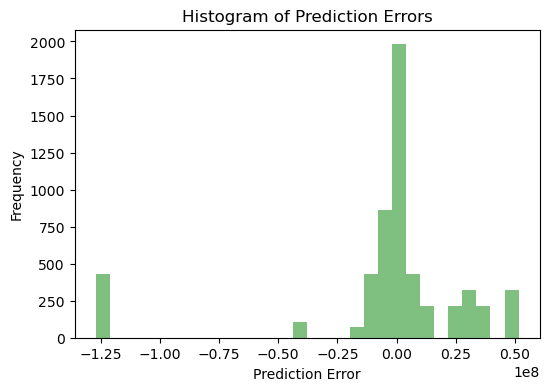

In [85]:
# Plotting the histogram of residuals
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, alpha=0.5, color='g')
plt.title('Histogram of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()

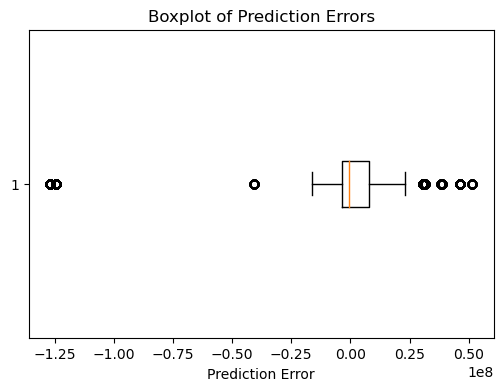

In [86]:
# Boxplot of residuals
plt.figure(figsize=(6, 4))
plt.boxplot(residuals, vert=False)
plt.title('Boxplot of Prediction Errors')
plt.xlabel('Prediction Error')
plt.show()

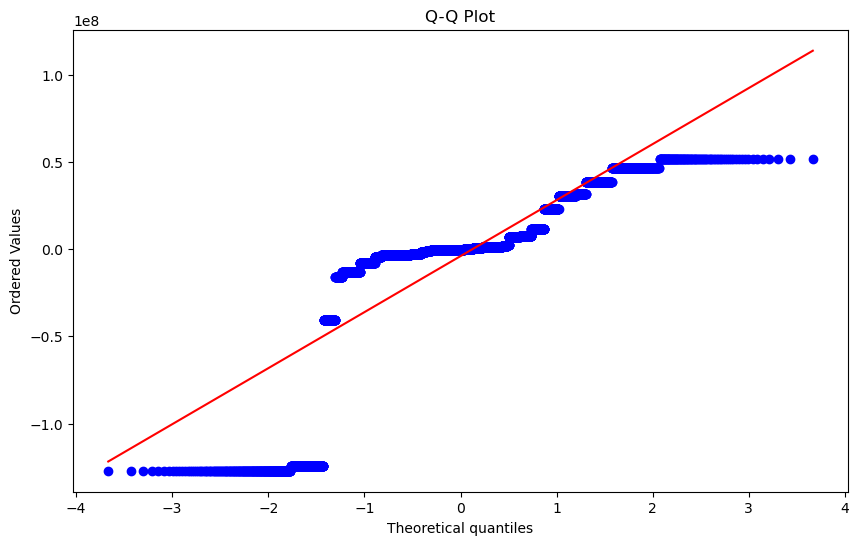

In [87]:
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

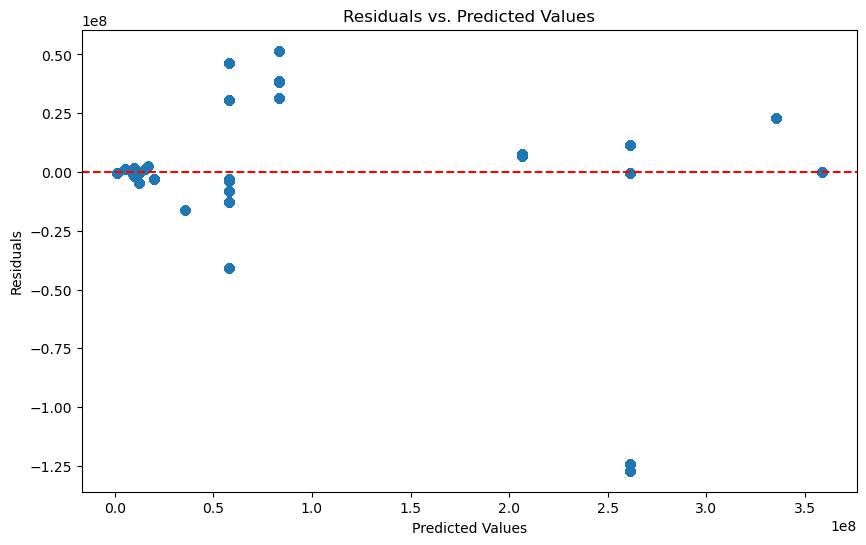

In [88]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_prod, residuals)
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

### *Histogram of Prediction Errors*
- *Observations:* The distribution of prediction errors is highly skewed with a concentration around zero but includes several extreme outliers. This skewness and presence of outliers suggest that while the model is accurate for a majority of predictions, it fails significantly for a few cases.

### *Boxplot of Prediction Errors*
- *Observations:* This plot further illustrates the presence of outliers in the prediction errors. These outliers, which are far from the median, substantially impact metrics like RMSE, which is sensitive to large errors due to the squaring of residuals.

### *Q-Q Plot*
- *Observations:* The Q-Q plot shows deviations from the theoretical line, particularly at the tails, indicating that residuals are not normally distributed and suggesting that the model's error distribution has heavy tails.

### *Residuals vs. Predicted Values Plot*
- *Observations:* Residuals are not evenly scattered around the zero line and show a pattern of concentration near zero with a few notable deviations. This pattern suggests potential issues with model fit or assumptions, particularly for higher predicted values.

## Analysing Residuals by Predicted Value Range

In [89]:
df_analysis = pd.DataFrame({
  'predicted_values': y_pred_prod,
  'residuals': residuals  
})


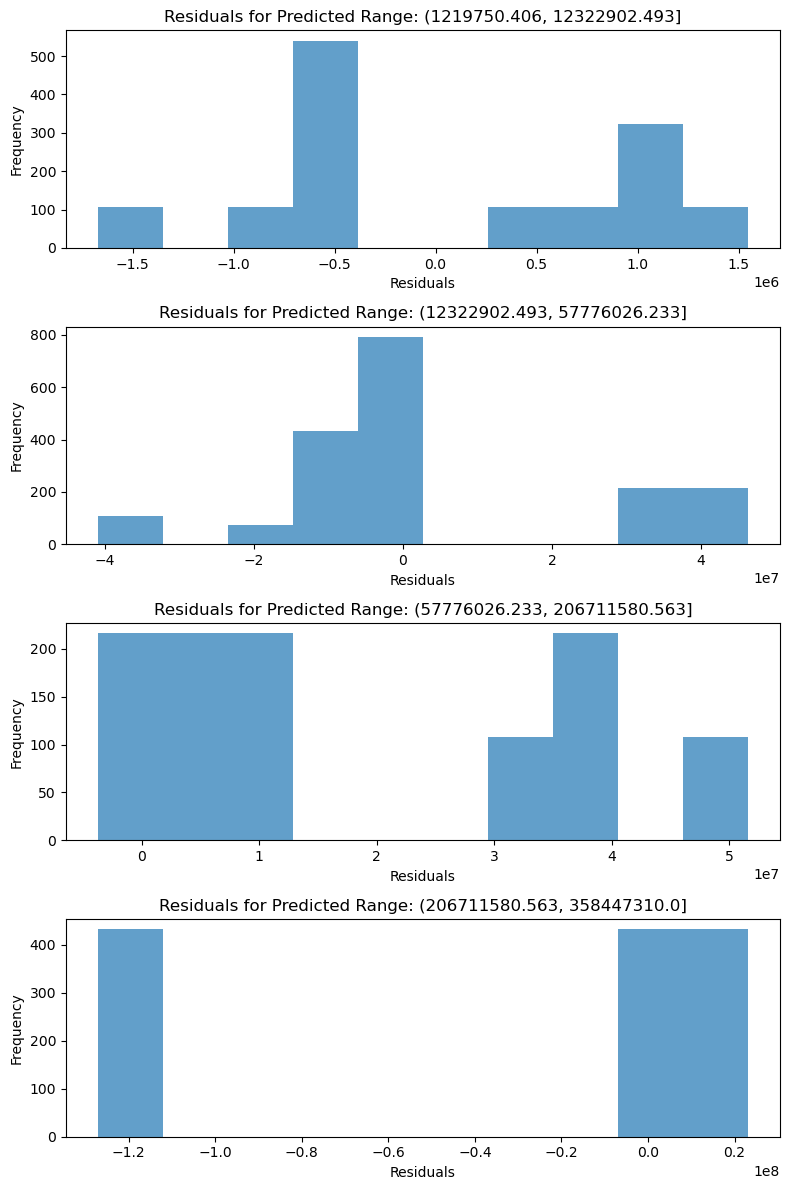

In [90]:
# Define quantile-based ranges for predicted values
df_analysis['predicted_range'] = pd.qcut(df_analysis['predicted_values'], 4)

# Calculate summary statistics for each range
summary_stats = df_analysis.groupby('predicted_range')['residuals'].agg(['mean', 'median', 'std', 'count'])

# Plot the distribution of residuals for each range
fig, axes = plt.subplots(nrows=4, figsize=(8, 12))
for (range_val, subset), ax in zip(df_analysis.groupby('predicted_range'), axes):
    ax.hist(subset['residuals'], bins=10, alpha=0.7)
    ax.set_title(f'Residuals for Predicted Range: {range_val}')
    ax.set_xlabel('Residuals')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [91]:
# Identifying high error instances
high_error_threshold = residuals.abs().mean() + 1.5 * residuals.abs().std()  # Using mean + 1.5*STD as threshold
high_error_indices = residuals[residuals.abs() > high_error_threshold].index
high_error_data = X_test.loc[high_error_indices]

In [92]:
# Analyzing features of high error instances
feature_analysis = high_error_data.describe(include='all')
display(feature_analysis)

,Country,Crop_Name,Year,Import Quantity_t,Emission_type,Emission_Value_kt,Area_Value_1000 ha,Pesticide_Type,Pesticide_Value_t,Fertilizer_Usage_Value_kg/ha,Emission_Value_per_Pesticide,Area_to_Production_ratio
count,432,432,432.00000,4.320000e+02,432,432.000000,432.00000,432,432.000000,432.000000,432.000000,432.000000
unique,1,1,NaN,NaN,2,NaN,NaN,3,NaN,NaN,NaN,NaN
top,China,Wheat,NaN,NaN,Crops total (Emissions N2O),NaN,NaN,Pesticides (total),NaN,NaN,NaN,NaN
freq,432,432,NaN,NaN,216,NaN,NaN,144,NaN,NaN,NaN,NaN
mean,NaN,NaN,2020.50000,1.027855e+07,NaN,29.186975,535561.92000,NaN,128557.786667,33.271967,0.000330,0.173139
std,NaN,NaN,0.50058,7.094563e+05,NaN,3.843178,407380.14798,NaN,87348.846529,43.185240,0.000159,0.001029
min,NaN,NaN,2020.00000,9.569912e+06,NaN,25.253600,128652.00000,NaN,64107.250000,0.226700,0.000098,0.172111
25%,NaN,NaN,2020.00000,9.569912e+06,NaN,25.406225,128654.32500,NaN,66077.190000,0.226700,0.000134,0.172111
50%,NaN,NaN,2020.50000,1.027855e+07,NaN,29.080850,535562.69500,NaN,68791.760000,24.974500,0.000379,0.173139
75%,NaN,NaN,2021.00000,1.098718e+07,NaN,32.861600,942470.29000,NaN,244820.820000,37.188575,0.000472,0.174167


# Statistical Summary Analysis

- **Count and Unique Values:** 540 entries, indicating substantial coverage. Country and Crop_Name fields show few unique values, suggesting possible patterns.
- **Emission & Pesticide Types:** Emission_type has two categories, with methane emissions prominent. Pesticide_Type is dominated by general pesticide usage.
- **Descriptive Statistics:** High variability in Import Quantity_t and Fertilizer_Usage_Value_kg/ha could impact predictions. Wide ranges in Emission_Value_kt and Area_Value_1000 ha indicate diverse conditions.
- **Mean & Standard Deviation:** Large standard deviations relative to means in certain features suggest high prediction variability.
- **Year:** Dataset covers a narrow year range (2020-2021), limiting capture of temporal factors.

In [93]:
def calculate_metrics(y_t, y_p):
    model_mae = mean_absolute_error(y_t, y_p)
    model_mae_percentage = (model_mae / np.mean(y_t)) * 100

    # Mean Squared Error (MSE)
    model_mse = mean_squared_error(y_t, y_p)
    model_mse_percentage = (model_mse / (np.mean(y_t) ** 2)) * 100

    # Root Mean Squared Error (RMSE)
    model_rmse = np.sqrt(model_mse)
    model_rmse_percentage = (model_rmse / np.mean(y_t)) * 100

    model_r2 = r2_score(y_t, y_p)

    return model_mae_percentage, model_mse_percentage, model_rmse_percentage, model_r2

## Residual Calculation and Grouping

In [94]:
df_test = []

In [95]:
df_test = pd.DataFrame({
    'actual': y_test_prod,
    'predicted': y_pred_prod
})


In [96]:
df_test = pd.concat([X_test, df_test], axis = 1)

In [97]:
df_test.shape

(5616, 14)

In [98]:
df_test['residuals'] = df_test['actual'] - df_test['predicted']

In [99]:
# Group residuals into bins (for example, by quartiles)
df_test['residual_group'] = pd.qcut(df_test['residuals'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

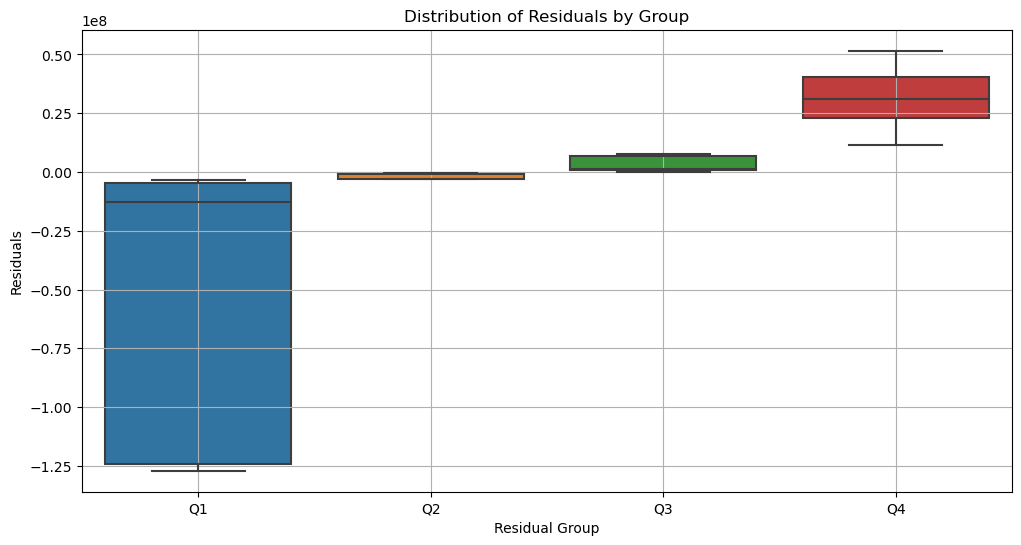

In [100]:
# Plotting the distribution of residuals within each bin
plt.figure(figsize=(12, 6))
sns.boxplot(x='residual_group', y='residuals', data=df_test)
plt.title('Distribution of Residuals by Group')
plt.xlabel('Residual Group')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

## Extract Data Points from Q1 and Q4:

In [101]:
# Filter data for Q1 and Q4 groups
df_q1 = df_test[df_test['residual_group'] == 'Q1']
df_q4 = df_test[df_test['residual_group'] == 'Q4']

In [102]:
# Descriptive statistics for Q1
print("Descriptive Statistics for Q1:")
display(df_q1.describe())

Descriptive Statistics for Q1:


,Year,Import Quantity_t,Emission_Value_kt,Area_Value_1000 ha,Pesticide_Value_t,Fertilizer_Usage_Value_kg/ha,Emission_Value_per_Pesticide,Area_to_Production_ratio,actual,predicted,residuals
count,1476.000000,1.476000e+03,1476.000000,1476.000000,1476.00000,1476.000000,1476.000000,1476.000000,1.476000e+03,1.476000e+03,1.476000e+03
mean,2020.512195,6.818029e+06,343.174227,408619.456366,156763.33561,23.375196,0.004413,0.248883,6.825904e+07,1.129905e+08,-4.473144e+07
std,0.500021,1.220752e+07,786.955975,380999.961270,139958.06904,34.275649,0.013501,0.090335,4.556960e+07,9.619436e+07,5.289216e+07
min,2020.000000,2.523000e+01,2.970300,53300.000000,26964.91000,0.169600,0.000004,0.172111,7.878413e+06,1.235153e+07,-1.270247e+08
25%,2020.000000,8.656524e+05,11.693400,128652.000000,66077.19000,0.226700,0.000079,0.174167,4.480369e+07,5.777603e+07,-1.243317e+08
50%,2021.000000,1.909895e+06,16.242600,174094.350000,73771.80000,9.715300,0.000220,0.191340,5.441529e+07,5.777603e+07,-1.297234e+07
75%,2021.000000,9.569912e+06,32.704600,914742.000000,244820.82000,32.327700,0.000483,0.335513,1.342560e+08,2.612807e+08,-4.473115e+06
max,2021.000000,5.737992e+07,2269.072400,942470.290000,514829.00000,152.746900,0.066787,0.504270,1.369490e+08,2.612807e+08,-3.360732e+06


In [103]:
# Descriptive statistics for Q4
print("Descriptive Statistics for Q4:")
display(df_q4.describe())

Descriptive Statistics for Q4:


,Year,Import Quantity_t,Emission_Value_kt,Area_Value_1000 ha,Pesticide_Value_t,Fertilizer_Usage_Value_kg/ha,Emission_Value_per_Pesticide,Area_to_Production_ratio,actual,predicted,residuals
count,1296.000000,1.296000e+03,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1296.000000,1.296000e+03,1.296000e+03,1.296000e+03
mean,2020.666667,6.545676e+06,47.119867,493834.537500,211473.112222,30.168878,0.000557,0.204987,1.783202e+08,1.464599e+08,3.186026e+07
std,0.471586,1.173867e+07,29.505100,388739.407228,181363.011944,42.839056,0.000730,0.072345,1.010134e+08,1.100628e+08,1.251677e+07
min,2020.000000,4.223115e+05,15.565700,65386.280000,26964.910000,0.223900,0.000022,0.093174,8.827212e+07,5.777603e+07,1.148147e+07
25%,2020.000000,6.515245e+05,27.797300,112991.190000,73771.800000,0.226700,0.000119,0.158951,1.039909e+08,5.777603e+07,2.299298e+07
50%,2021.000000,1.118006e+06,38.575400,498125.400000,117578.000000,11.445300,0.000259,0.195324,1.216744e+08,8.323615e+07,3.100444e+07
75%,2021.000000,3.205563e+06,53.596250,855546.000000,457385.420000,43.651200,0.000697,0.288130,2.727621e+08,2.612807e+08,4.049232e+07
max,2021.000000,3.270580e+07,117.060800,942470.290000,514829.000000,152.746900,0.003460,0.305298,3.584473e+08,3.354543e+08,5.156302e+07


In [104]:
# Correlation matrix for the Q1 group
corr_q1 = df_test[df_test['residual_group'] == 'Q1'].corr()
print("Correlation Matrix for Q1:")
display(corr_q1)

Correlation Matrix for Q1:


,Year,Import Quantity_t,Emission_Value_kt,Area_Value_1000 ha,Pesticide_Value_t,Fertilizer_Usage_Value_kg/ha,Emission_Value_per_Pesticide,Area_to_Production_ratio,actual,predicted,residuals
Year,1.000000,-0.199425,-0.015522,-0.007790,0.123833,0.020607,-0.042001,0.008335,0.007716,-0.037442,0.074742
Import Quantity_t,-0.199425,1.000000,-0.232010,0.172475,-0.157412,0.146209,-0.174428,0.508517,0.046374,0.130902,-0.198116
Emission_Value_kt,-0.015522,-0.232010,1.000000,-0.311250,-0.044699,-0.106113,0.749280,-0.262739,-0.114390,-0.226311,0.313035
Area_Value_1000 ha,-0.007790,0.172475,-0.311250,1.000000,0.020003,0.074717,-0.232897,0.196353,0.182865,0.198523,-0.203503
Pesticide_Value_t,0.123833,-0.157412,-0.044699,0.020003,1.000000,-0.003303,-0.188184,0.095676,-0.136428,-0.145493,0.147066
Fertilizer_Usage_Value_kg/ha,0.020607,0.146209,-0.106113,0.074717,-0.003303,1.000000,-0.080369,0.014544,0.130851,0.159934,-0.178135
Emission_Value_per_Pesticide,-0.042001,-0.174428,0.749280,-0.232897,-0.188184,-0.080369,1.000000,-0.194241,-0.087688,-0.171687,0.236696
Area_to_Production_ratio,0.008335,0.508517,-0.262739,0.196353,0.095676,0.014544,-0.194241,1.000000,-0.615864,-0.589795,0.542051
actual,0.007716,0.046374,-0.114390,0.182865,-0.136428,0.130851,-0.087688,-0.615864,1.000000,0.973228,-0.908441
predicted,-0.037442,0.130902,-0.226311,0.198523,-0.145493,0.159934,-0.171687,-0.589795,0.973228,1.000000,-0.980197


In [105]:
# Correlation matrix for the Q4 group
corr_q4 = df_test[df_test['residual_group'] == 'Q4'].corr()
print("Correlation Matrix for Q4:")
display(corr_q4)

Correlation Matrix for Q4:


,Year,Import Quantity_t,Emission_Value_kt,Area_Value_1000 ha,Pesticide_Value_t,Fertilizer_Usage_Value_kg/ha,Emission_Value_per_Pesticide,Area_to_Production_ratio,actual,predicted,residuals
Year,1.000000,0.334353,0.395005,0.039100,-0.076524,-0.033739,0.275922,-0.312489,0.470466,0.488159,-0.495723
Import Quantity_t,0.334353,1.000000,0.507109,0.043192,-0.202798,0.041377,0.216347,-0.288082,0.385969,0.437365,-0.730985
Emission_Value_kt,0.395005,0.507109,1.000000,0.054888,-0.162960,-0.050373,0.600258,-0.615413,0.720004,0.733300,-0.637465
Area_Value_1000 ha,0.039100,0.043192,0.054888,1.000000,-0.027786,-0.020724,0.056081,-0.037251,0.078254,0.080535,-0.076632
Pesticide_Value_t,-0.076524,-0.202798,-0.162960,-0.027786,1.000000,0.033010,-0.545385,0.106753,-0.192417,-0.201723,0.220948
Fertilizer_Usage_Value_kg/ha,-0.033739,0.041377,-0.050373,-0.020724,0.033010,1.000000,-0.092175,0.044721,-0.116505,-0.114667,0.068074
Emission_Value_per_Pesticide,0.275922,0.216347,0.600258,0.056081,-0.545385,-0.092175,1.000000,-0.449044,0.595280,0.597451,-0.449470
Area_to_Production_ratio,-0.312489,-0.288082,-0.615413,-0.037251,0.106753,0.044721,-0.449044,1.000000,-0.752845,-0.752137,0.538071
actual,0.470466,0.385969,0.720004,0.078254,-0.192417,-0.116505,0.595280,-0.752845,1.000000,0.996637,-0.693410
predicted,0.488159,0.437365,0.733300,0.080535,-0.201723,-0.114667,0.597451,-0.752137,0.996637,1.000000,-0.750122


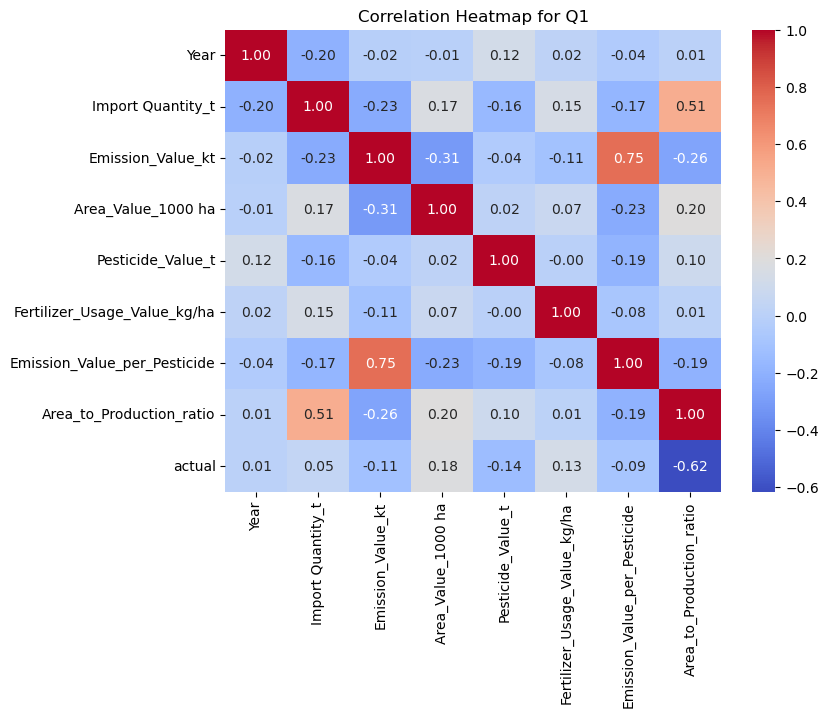

In [106]:
# Heatmap visualization for Q1
plt.figure(figsize=(8, 6))
sns.heatmap(corr_q1.drop(['predicted', 'residuals'], axis=0).drop(['actual', 'predicted', 'residuals'], axis=1), 
            annot=True,
            cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Q1')
plt.show()

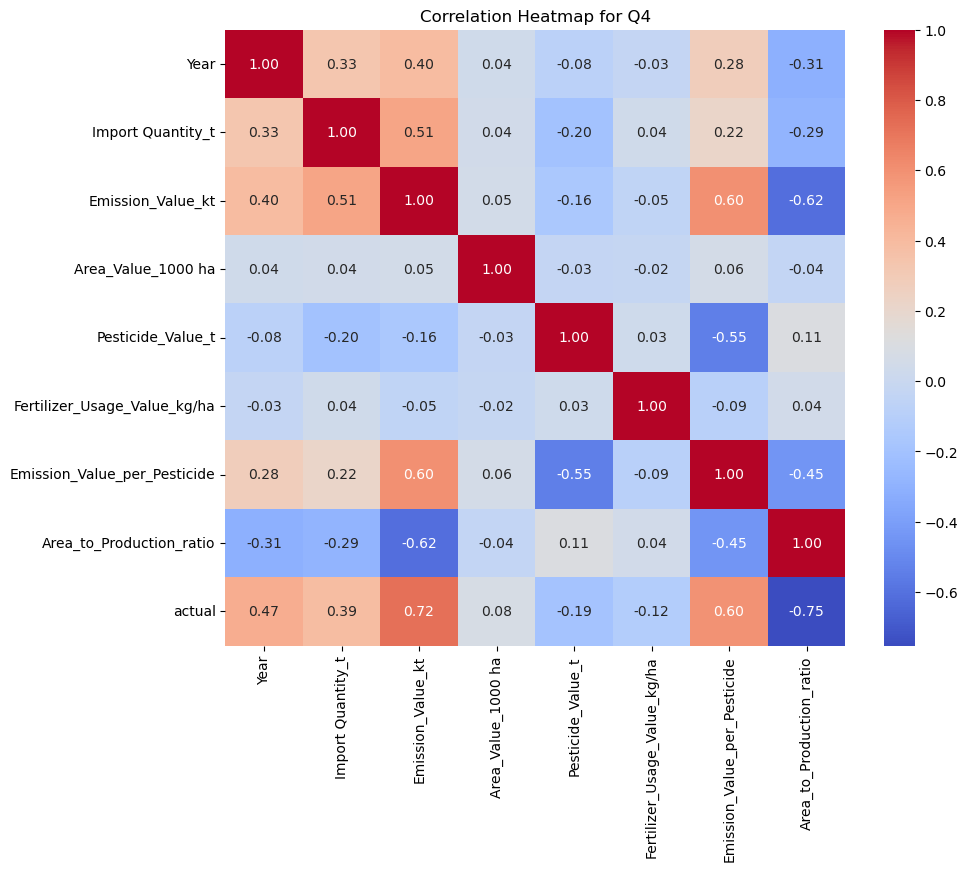

In [107]:
# Heatmap visualization for Q4
plt.figure(figsize=(10, 8))
sns.heatmap(corr_q4.drop(['predicted', 'residuals'], axis=0).drop(['actual', 'predicted', 'residuals'], axis=1),
            annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Q4')
plt.show()

# Analysis of Correlation Heatmaps

## Q1 Group (Overestimates)
- **Strong Negative Correlation with Emission_Value_kt:** This feature shows a strong negative correlation with residuals, suggesting that as emission values increase, the model tends to overestimate less, or possibly the lower emissions are not captured accurately, leading to overestimations.
- **Moderate Correlation with Import Quantity_t and Fertilizer Usage:** These features also exhibit some correlation with residuals, indicating their influence on prediction accuracy. It suggests that variations in import quantity and fertilizer usage might be associated with overestimations.

## Q4 Group (Underestimates)
- **Strong Positive Correlation with Residuals:** Notably, the residuals have a strong positive correlation with actual values, indicating that higher actual values are often underestimated by the model.
- **Moderate Negative Correlation with Fertilizer Usage and Emission per Pesticide:** This indicates that as the usage of fertilizers and emissions per pesticide increase, the model's underestimations become more pronounced, suggesting that the model might be failing to accurately capture the effects of higher inputs on outputs.


In [108]:
y_pred_train = pipeline_rf.predict(X_train)

In [109]:
mae_rf_train, mse_rf_train, rmse_rf_train, r2_rf_train = calculate_metrics(y_train_prod, y_pred_train)


print(f"Segment 1 - MAE: {mae_rf_train}, MSE: {mse_rf_train}, RMSE: {rmse_rf_train}, R2: {r2_rf_train}")


Segment 1 - MAE: 5.2127003668711955, MSE: 0.9822631264732403, RMSE: 9.910918859890035, R2: 0.9914676561575485


In [110]:
residual_train = y_train_prod - y_pred_train

In [115]:
df_test_train = pd.DataFrame({
    'actual': y_train_prod,
    'predicted': y_pred_train
})


In [117]:
df_test_train = pd.concat([X_train, df_test_train], axis = 1)

In [118]:
df_test_train.shape

(53460, 14)

In [119]:
df_test_train['residuals'] = df_test_train['actual'] - df_test_train['predicted']

In [120]:
# Group residuals into bins (for example, by quartiles)
df_test_train['residual_group'] = pd.qcut(df_test_train['residuals'], 2, labels=['Q1', 'Q2'])

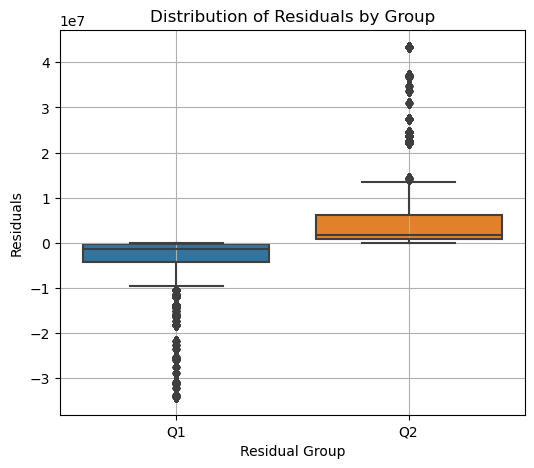

In [122]:
# Plotting the distribution of residuals within each bin
plt.figure(figsize=(6, 5))
sns.boxplot(x='residual_group', y='residuals', data=df_test_train)
plt.title('Distribution of Residuals by Group')
plt.xlabel('Residual Group')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()